
## Section 1: Problem Formulation

### Introduction:
In this project, we aim to explore the effectiveness of contrastive learning, specifically using the SimCLR algorithm, 
for image classification tasks under the constraint of having limited labeled data. Contrastive learning is a technique 
in self-supervised learning that learns to encode similar items closer in the feature space while pushing dissimilar items further apart.


In [1]:
from tqdm import tqdm
import os
import sys

In [2]:
# Import necessary libraries
import torch
import torchvision
from torch import nn

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
args = {
    "dataset": "cifar10",
    "model": "resnet50",
    "batch_size": 1024,
    "sample_rate": 1,
    "epochs": 100,
    "n_views": 2,
    "out_dim": 128,
    "lr": 12e-4,
    "wd": 1e-6,
    "log_every_n_steps": 5,
    "n_workers": 16,
    "temperature": 0.07,
}


## Section 2: Dataset Preparations

In this section, we will prepare the CIFAR-10, CIFAR-100, and MedMNIST datasets for training. 
We will apply necessary transformations and split the datasets into training, validation, and test sets.


In [4]:
from dataset import SimCLRDataset
data = SimCLRDataset(args["dataset"])
build_dataloader = lambda dataset: torch.utils.data.DataLoader(
    dataset,
    batch_size=args["batch_size"],
    shuffle=True,
    drop_last=True,
    num_workers=args["n_workers"],
)

train_dataset = data.get_train_dataset(n_views=args["n_views"], sample_rate=args["sample_rate"])
train_loader = build_dataloader(train_dataset)

test_dataset = data.get_test_dataset(n_views=args["n_views"])
test_loader = build_dataloader(test_dataset)
print("# Train samples:", len(train_dataset))
print("# Test samples:", len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
# Train samples: 50000
# Test samples: 10000


## Section 3: Deep Learning Model

In this section, we will prepare the popular choice of deep learning model like ResNet18 and VGG16.


In [5]:
from model import SimCLRCNN 
contrastive_model = SimCLRCNN(backbone=args["model"], out_dim=args["out_dim"])
contrastive_model = contrastive_model.to(device)
contrastive_model = torch.compile(contrastive_model) if not sys.platform.startswith("win") else contrastive_model


## Section 4: Contrastive Training

In [6]:
from utils import metric, info_nce_loss
info_nce_loss = torch.compile(info_nce_loss) if sys.platform == "linux" else info_nce_loss
torch.set_float32_matmul_precision('high')

def contrastive_evaluation(model, test_loader, device, criterion, args):
    model.eval()
    total_loss = 0.0
    total_top1 = 0.0
    total_top5 = 0.0
    total_num = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = torch.cat(images, dim=0).to(device)
            features = model(images)
            logits, labels = info_nce_loss(features, device, args)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            top1, top5 = metric(logits, labels, topk=(1, 5))
            total_top1 += top1.item()
            total_top5 += top5.item()
            total_num += 1
    model.train()
    return {
        "loss": total_loss / total_num,
        "top1": total_top1 / total_num,
        "top5": total_top5 / total_num,
    }
    

In [8]:
def contrastive_training(model, train_loader, test_loader, args):
    os.makedirs("checkpoints", exist_ok=True)
    n_iter = 0
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['wd'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0, last_epoch=-1)
    records = []
    test_records = []

    for epoch_counter in range(args['epochs']):

        for images, _ in tqdm(train_loader):
            images = torch.cat(images, dim=0)
            images = images.to(device)
            features = model(images)
            logits, labels = info_nce_loss(features, device, args)
            loss = criterion(logits, labels)
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()
            n_iter += 1
        
        print(f"Epoch: {epoch_counter}\tLoss: {loss.item():.4f}\t")
        records.append({"epoch": epoch_counter, "loss": loss.item()})
        if epoch_counter >= 10:
            scheduler.step()

        if epoch_counter % args["log_every_n_steps"] == 0:
            eval_res = contrastive_evaluation(model, test_loader, device, criterion, args)
            top1, top5 = eval_res["top1"], eval_res["top5"]
            test_loss = eval_res["loss"]
            print(f"Epoch: {epoch_counter}\tTop1 accuracy: {top1:.4f}\tTop5 accuracy: {top5:.4f}\tTest loss: {test_loss:.4f}")
            torch.save(model.state_dict(), f"checkpoints/{args['model']}_{args['dataset']}_{epoch_counter}.pt")
            test_records.append(eval_res)

    print("Training has finished.")
    # save model checkpoints
    torch.save(model.state_dict(), f"checkpoints/{args['model']}_{args['dataset']}_{epoch_counter}.pt")
    return records, test_records

train_records, test_records = contrastive_training(contrastive_model, train_loader, test_loader, args)

  0%|          | 0/48 [00:00<?, ?it/s]/home/levscaut/anaconda3/lib/python3.9/site-packages/torch/_inductor/compile_fx.py:140: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
100%|██████████| 48/48 [00:43<00:00,  1.11it/s]


Epoch: 0	Loss: 7.4660	
Epoch: 0	Top1 accuracy: 0.1790	Top5 accuracy: 0.6293	Test loss: 7.7915


100%|██████████| 48/48 [00:10<00:00,  4.43it/s]


Epoch: 1	Loss: 7.3508	


100%|██████████| 48/48 [00:10<00:00,  4.37it/s]


Epoch: 2	Loss: 7.3092	


100%|██████████| 48/48 [00:10<00:00,  4.39it/s]


Epoch: 3	Loss: 7.1990	


100%|██████████| 48/48 [00:11<00:00,  4.28it/s]


Epoch: 4	Loss: 7.0985	


100%|██████████| 48/48 [00:11<00:00,  4.26it/s]

Epoch: 5	Loss: 7.1398	


Epoch: 5	Top1 accuracy: 0.4015	Top5 accuracy: 1.5516	Test loss: 7.2029


100%|██████████| 48/48 [00:11<00:00,  4.17it/s]


Epoch: 6	Loss: 7.0582	


100%|██████████| 48/48 [00:11<00:00,  4.13it/s]


Epoch: 7	Loss: 6.9310	


100%|██████████| 48/48 [00:11<00:00,  4.21it/s]


Epoch: 8	Loss: 6.9118	


100%|██████████| 48/48 [00:11<00:00,  4.15it/s]


Epoch: 9	Loss: 6.8055	


100%|██████████| 48/48 [00:11<00:00,  4.21it/s]


Epoch: 10	Loss: 6.6988	
Epoch: 10	Top1 accuracy: 1.5408	Top5 accuracy: 5.3711	Test loss: 6.8192


100%|██████████| 48/48 [00:11<00:00,  4.13it/s]


Epoch: 11	Loss: 6.7518	


100%|██████████| 48/48 [00:11<00:00,  4.10it/s]


Epoch: 12	Loss: 6.7345	


100%|██████████| 48/48 [00:11<00:00,  4.16it/s]


Epoch: 13	Loss: 6.6227	


  0%|          | 0/48 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
import pandas as pd
df = pd.DataFrame.from_records(train_records)
test_df = pd.DataFrame.from_records(test_records)
df.to_csv(f"logs/{args['model']}_{args['dataset']}_train.csv", index=False)
test_df.to_csv(f"logs/{args['model']}_{args['dataset']}_test.csv", index=False)
display(test_df)

,loss,top1,top5
0,5.985841,10.698785,20.930990
1,5.236135,19.596354,33.138021
2,4.917688,23.980035,38.107639
3,4.747441,25.851780,40.212674
4,4.332738,31.494141,46.408420
5,4.053542,35.232205,50.157335
6,3.892925,37.782118,52.544488
7,3.686255,40.717231,55.474175
8,3.409119,43.397352,58.924696
9,3.386629,44.661458,59.364149


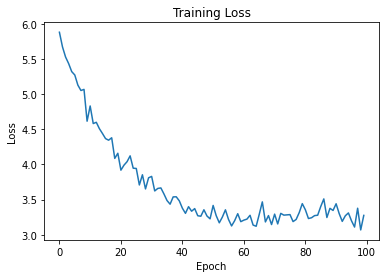

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

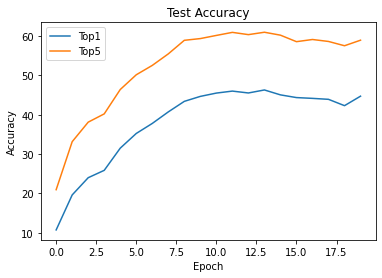

In [ ]:
plt.plot(test_df['top1'])
plt.plot(test_df['top5'])
plt.legend(['Top1', 'Top5'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.show()


## Section 5: Baseline


In [ ]:
raise Exception("Please manually start baseline.")

In [ ]:
standard_train_dataset = data.get_train_dataset(n_views=1, sample_rate=args["sample_rate"])
standard_train_loader = build_dataloader(standard_train_dataset)
standard_test_dataset = data.get_test_dataset(n_views=1)
standard_test_loader = build_dataloader(standard_test_dataset)
num_classes = data.num_classes

print("# Standard Train samples:", len(standard_train_dataset))
print("# Standard Test samples:", len(standard_test_dataset))

In [ ]:
from torchvision.models import resnet18, vgg16
model_dict = {
    "resnet18": resnet18,
    "vgg16": vgg16,
}
standard_model = model_dict[args["model"]](num_classes=num_classes)
standard_model = standard_model.to(device)
standard_model = torch.compile(standard_model) if not sys.platform.startswith("win") else standard_model

In [ ]:
from utils import metric
def standard_evaluation(model, test_loader, device, criterion, args):
    model.eval()
    total_loss = 0.0
    total_top1 = 0.0
    total_top5 = 0.0
    total_num = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            top1, top5 = metric(logits, labels, topk=(1, 5))
            total_top1 += top1.item()
            total_top5 += top5.item()
            total_num += 1
    model.train()

    return {
        "loss": total_loss / total_num,
        "top1": total_top1 / total_num,
        "top5": total_top5 / total_num,
    }


In [ ]:
def standard_training(model, train_loader, test_loader, args):
    os.makedirs("checkpoints", exist_ok=True)
    n_iter = 0
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['wd'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0, last_epoch=-1)
    records = []
    test_records = []

    for epoch_counter in range(args['epochs']):

        for images, labels in tqdm(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()
            n_iter += 1
        
        print(f"Epoch: {epoch_counter}\tLoss: {loss.item():.4f}\t")
        records.append({"epoch": epoch_counter, "loss": loss.item()})
        if epoch_counter >= 10:
            scheduler.step()

        if epoch_counter % args["log_every_n_steps"] == 0:
            eval_res = standard_evaluation(model, test_loader, device, criterion, args)
            top1, top5 = eval_res["top1"], eval_res["top5"]
            test_loss = eval_res["loss"]
            print(f"Epoch: {epoch_counter}\tTop1 accuracy: {top1:.4f}\tTop5 accuracy: {top5:.4f}\tTest loss: {test_loss:.4f}")
            torch.save(model.state_dict(), f"checkpoints/{args['model']}_{args['dataset']}_{epoch_counter}.pt")
            test_records.append(eval_res)

    print("Training has finished.")
    # save model checkpoints
    torch.save(model.state_dict(), f"checkpoints/{args['model']}_{args['dataset']}_{epoch_counter}.pt")
    return records, test_records

standard_records, standard_test_records = standard_training(standard_model, standard_train_loader, standard_test_loader, args)